In [18]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import plot_tree

import seaborn as sn

In [19]:
! pip install --upgrade --no-cache-dir gdown

^C


nltk 3.8.1 requires click, which is not installed.
You are using pip version 19.0.3, however version 23.3.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
!gdown 16R0g3vPfnf87A7x9H3OfI2zf8lkpEzjI
!gdown 1j4k-CAfXEId6QytCW01LCdT0CDEHTIbo

Downloading...
From: https://drive.google.com/uc?id=16R0g3vPfnf87A7x9H3OfI2zf8lkpEzjI
To: /content/test.xlsx
100% 112k/112k [00:00<00:00, 52.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1j4k-CAfXEId6QytCW01LCdT0CDEHTIbo
To: /content/train.xlsx
100% 830k/830k [00:00<00:00, 28.1MB/s]


In [3]:
train = pd.read_excel("data/train.xlsx")
test  = pd.read_excel("data/test.xlsx")

# Предобработка данных

In [4]:
def collect_data(data):
    sent, em = [], []
    for i in range(len(data)):
        raw = data["column"][i].split(";")
        sent.append(raw[0])
        em.append(raw[1])

    dic = {"Sent":sent, "Em":em}
    df_raw = pd.DataFrame(dic, dtype=str)
    return df_raw

In [5]:
df_train_raw = collect_data(train)
df_test_raw = collect_data(test)
df_raw = pd.concat([df_train_raw, df_test_raw], ignore_index=True, sort=False)
df_raw.sample(4, random_state=18)

,Sent,Em
8763,i have reason to wonder to be confused to feel...,anger
520,i really lose a lot of my nesting homemaking i...,joy
7108,i feel excuse the messy thoughts i cant wait t...,sadness
3074,i feel thank you everyone for the amazing thou...,joy


In [6]:
pd.isnull(df_raw).sum()

Sent    0
Em      0
dtype: int64

<AxesSubplot:ylabel='Em'>

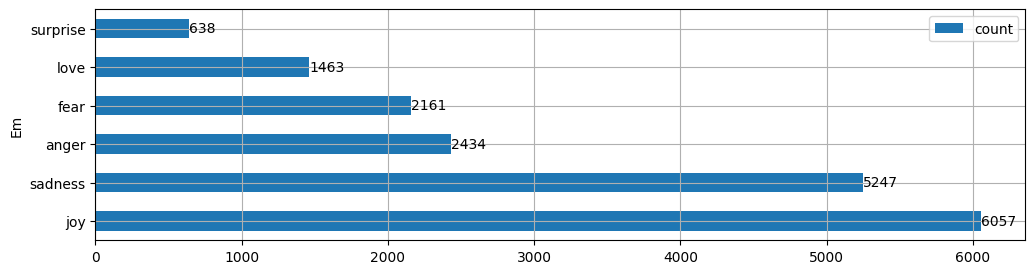

In [7]:
keys = df_raw.groupby(by=['Em']).agg(count=('Em', 'count'))
bar = keys.sort_values(by='count', ascending=False).plot(
    kind='barh',
    label="Number of emoution in messages",
    legend=True,
    grid=True,
    figsize=(12,3),
)

bar.bar_label(bar.containers[0])
bar

In [9]:
import requests
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
nltk.download('punkt')
nltk.download('stopwords')
stop_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
punctuation = punctuation + "“”—’"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [164]:
# yandex_api_base = "https://speller.yandex.net/services/spellservice.json"
# check_text_suffix = "/checkText?text="

# def fix_typo_word(uncorrect_word):
#    req = requests.get(yandex_api_base + check_text_suffix + uncorrect_word)
#    if (req):
#       if (len(req.json()) > 0):
#         return req.json()[0]['s'][0]
#       return uncorrect_word

# def fix_typo_sentence(uncorrect_sent):
#     req = requests.get(yandex_api_base + check_text_suffix + uncorrect_sent)
#     if (req):
#         if (len(req.json()) > 0):
#             return req.json()[0]['s'][0]
#         return uncorrect_sent

In [20]:
def get_lower_tokenized(x):
    # tokenized = word_tokenize(fix_typo_sentence(x))
    tokenized = word_tokenize(x)
    lower_words = [word.lower() for word in tokenized if not word in punctuation]
    return lower_words

def get_wsw_nltk(x):
    return [word for word in x if not word in stop_en]

def get_stemmed(x):
    return [stemmer_en.stem(word) for word in x]

def concat(x):
    return ' '.join(x)


def prepare(df_raw):
    step1 = pd.DataFrame(df_raw.Sent.apply(lambda x: get_lower_tokenized(x)))
    step1.rename(columns={'Sent': 'tokenized'}, inplace=True)

    crit1 = pd.DataFrame(step1.tokenized.apply(lambda x: get_stemmed(x)))
    crit2 = pd.DataFrame(crit1.tokenized.apply(lambda x: concat(x)))

    crit3 = pd.DataFrame(step1.tokenized.apply(lambda x: get_stemmed(get_wsw_nltk(x))))
    crit4 = pd.DataFrame(crit3.tokenized.apply(lambda x: concat(x)))

    crit1.rename(columns={'tokenized': 'tokenized_stemmed'}, inplace=True)
    crit2.rename(columns={'tokenized': 'stemmed'}, inplace=True)

    crit3.rename(columns={'tokenized': 'tokenized_wsw_stemmed'}, inplace=True)
    crit4.rename(columns={'tokenized': 'wsw_stemmed'}, inplace=True)

    df = pd.concat([df_raw, crit1, crit2, crit3, crit4], axis=1)
    return df

In [21]:
df = prepare(df_raw)
df.sample(4, random_state=18)

,Sent,Em,tokenized_stemmed,stemmed,tokenized_wsw_stemmed,wsw_stemmed
8763,i have reason to wonder to be confused to feel...,anger,"[i, have, reason, to, wonder, to, be, confus, ...",i have reason to wonder to be confus to feel a...,"[reason, wonder, confus, feel, anger, say, you...",reason wonder confus feel anger say your selfi...
520,i really lose a lot of my nesting homemaking i...,joy,"[i, realli, lose, a, lot, of, my, nest, homema...",i realli lose a lot of my nest homemak instinc...,"[realli, lose, lot, nest, homemak, instinct, d...",realli lose lot nest homemak instinct desir pr...
7108,i feel excuse the messy thoughts i cant wait t...,sadness,"[i, feel, excus, the, messi, thought, i, cant,...",i feel excus the messi thought i cant wait to ...,"[feel, excus, messi, thought, cant, wait, make...",feel excus messi thought cant wait make new fr...
3074,i feel thank you everyone for the amazing thou...,joy,"[i, feel, thank, you, everyon, for, the, amaz,...",i feel thank you everyon for the amaz thought ...,"[feel, thank, everyon, amaz, thought, prayer]",feel thank everyon amaz thought prayer


In [22]:
def vectorising(vectorizer, df, fit_column, key_column="Em", bound=12000):
   X_vect = vectorizer.fit_transform(df[fit_column])
   x_train, y_train, x_test, y_test = X_vect[:bound], df[key_column][:bound], X_vect[bound:], df[key_column][bound:]
   return x_train, y_train, x_test, y_test

In [23]:
count_vect = CountVectorizer()
tfidf_vect = TfidfVectorizer()

In [24]:
x_train_1, y_train_1, x_test_1, y_test_1 = vectorising(count_vect, df, "Sent")
x_train_2, y_train_2, x_test_2, y_test_2 = vectorising(tfidf_vect, df, "Sent")

x_train_3, y_train_3, x_test_3, y_test_3 = vectorising(count_vect, df, "wsw_stemmed")
x_train_4, y_train_4, x_test_4, y_test_4 = vectorising(tfidf_vect, df, "wsw_stemmed")

# Обучение моделий

In [25]:
model1 = MultinomialNB()
model1.fit(x_train_1, y_train_1)
nb1 = model1.predict(x_test_1)

In [26]:
model2 = MultinomialNB()
model2.fit(x_train_2, y_train_2)
nb2 = model2.predict(x_test_2)

In [27]:
tree1 = DecisionTreeClassifier(random_state=343)
tree1.fit(x_train_1, y_train_1)
t_predict1 = tree1.predict(x_test_1)

In [28]:
tree2 = DecisionTreeClassifier(random_state=343)
tree2.fit(x_train_2, y_train_2)
t_predict2 = tree2.predict(x_test_2)

In [29]:
tree3 = DecisionTreeClassifier(random_state=343)
tree3.fit(x_train_3, y_train_3)
t_predict3 = tree3.predict(x_test_3)

In [30]:
tree4 = DecisionTreeClassifier(random_state=343)
tree4.fit(x_train_4, y_train_4)
t_predict4 = tree4.predict(x_test_4)

# Визуализация результатов

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support



*   Balanced Accuracy Score returns an average recall of each class in classification problem. It's useful to deal with imbalanced datasets.
*   The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label a negative sample as positive.
*   The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
*   The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0. The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.




In [32]:
def metrics(y_true, y_pred, message, f_beta=1, average='macro'):
  res = precision_recall_fscore_support(y_true, y_pred, beta=f_beta, average=average, zero_division=0)
  precision_sc, recall_sc, f_beta_sc = res[0], res[1], res[2]
  balanced_accuracy_sc = balanced_accuracy_score(y_true, y_pred)
  report = classification_report(y_true, y_pred)
  print(message)
  print(f'\tbalanced accuracy score: {balanced_accuracy_sc:.3f}')
  print(f'\tprecision score: {precision_sc:.3f}')
  print(f'\trecall score: {recall_sc:.3f}')
  print(f'\tF-{f_beta} score: {f_beta_sc:.3f}')
  #print(report)

In [33]:
metrics(y_test_1, nb1, "Naive Bias CountVectorizer")
metrics(y_test_2, nb2, "Naive Bias TfIdVect")
metrics(y_test_1, t_predict1, "DecisionTreeClassifier CountVectorizer Sent")
metrics(y_test_2, t_predict2, "DecisionTreeClassifier TfIdVect")
metrics(y_test_3, t_predict3, "DecisionTreeClassifier CountVectorizer nltk")
metrics(y_test_4, t_predict4, "DecisionTreeClassifier TfIdVect nltk")

Naive Bias CountVectorizer
	balanced accuracy score: 0.512
	precision score: 0.844
	recall score: 0.512
	F-1 score: 0.540


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Naive Bias TfIdVect
	balanced accuracy score: 0.353
	precision score: 0.691
	recall score: 0.353
	F-1 score: 0.324
DecisionTreeClassifier CountVectorizer Sent
	balanced accuracy score: 0.828
	precision score: 0.814
	recall score: 0.828
	F-1 score: 0.821
DecisionTreeClassifier TfIdVect
	balanced accuracy score: 0.799
	precision score: 0.797
	recall score: 0.799
	F-1 score: 0.798
DecisionTreeClassifier CountVectorizer nltk
	balanced accuracy score: 0.763
	precision score: 0.738
	recall score: 0.763
	F-1 score: 0.749
DecisionTreeClassifier TfIdVect nltk
	balanced accuracy score: 0.760
	precision score: 0.735
	recall score: 0.760
	F-1 score: 0.746


In [34]:
def printer(atrue, predict, name=""):
    labels = sorted(list(atrue.unique()))
    conf   = confusion_matrix(atrue, predict)

    plt.title(name)
    sn.set(font_scale=1.4) # for label size
    ax = sn.heatmap(conf, annot=True, annot_kws={"size": 12}) # font size
    ax.xaxis.set_ticklabels(labels, fontsize=12)
    ax.yaxis.set_ticklabels(labels, fontsize=12)
    plt.xlabel("predicted", fontsize = 15)
    plt.ylabel("true" , fontsize = 15)
    plt.show()

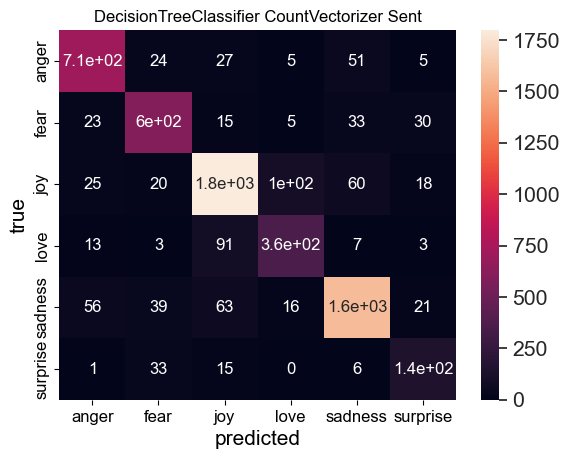

In [35]:
printer( y_test_1, t_predict1, "DecisionTreeClassifier CountVectorizer Sent")

Подведем итог в этой части: легко заметим, что лучше всех прочих чебя показала модель 
"DecisionTreeClassifier CountVectorizer Sent"

## Работа с Гиперпараметрами
Т.к. DecisionTreeClassifier оказалась оптимальной моделью, давайте переберем различные гиперпараметры в ней и определим, возможно ли улучшить показатели модели.

In [43]:
for parameter in tree1.get_params():
    print(parameter)

ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
random_state
splitter


Из всех параметров рассмотрим max_depth и max_leaf_nodes

#### Анализ max_depth

In [86]:
tree1_d15 = DecisionTreeClassifier(random_state=343, max_depth=15)
tree1_d15.fit(x_train_1, y_train_1)
t_predict1_d15 = tree1_d15.predict(x_test_1)

tree1_d100 = DecisionTreeClassifier(random_state=343, max_depth=100)
tree1_d100.fit(x_train_1, y_train_1)
t_predict1_d100 = tree1_d100.predict(x_test_1)

tree1_d200 = DecisionTreeClassifier(random_state=343, max_depth=200)
tree1_d200.fit(x_train_1, y_train_1)
t_predict1_d200 = tree1_d200.predict(x_test_1)

tree1_d300 = DecisionTreeClassifier(random_state=343, max_depth=300)
tree1_d300.fit(x_train_1, y_train_1)
t_predict1_d300 = tree1_d300.predict(x_test_1)

tree1_d400 = DecisionTreeClassifier(random_state=343, max_depth=400)
tree1_d400.fit(x_train_1, y_train_1)
t_predict1_d400 = tree1_d400.predict(x_test_1)

In [82]:
metrics(y_test_1, t_predict1_d15,average="macro", message="DecisionTreeClassifier-CV-Sent-depth=15")
metrics(y_test_1, t_predict1_d100,average="macro", message="DecisionTreeClassifier-CV-Sent-depth=100")
metrics(y_test_1, t_predict1_d200,average="macro", message="DecisionTreeClassifier-CV-Sent-depth=200")
metrics(y_test_1, t_predict1_d300,average="macro", message="DecisionTreeClassifier-CV-Sent-depth=300")
metrics(y_test_1, t_predict1_d400,average="macro", message="DecisionTreeClassifier-CV-Sent-depth=400")

DecisionTreeClassifier-CV-Sent-depth=15
	balanced accuracy score: 0.282
	precision score: 0.548
	recall score: 0.282
	F-1 score: 0.255
DecisionTreeClassifier-CV-Sent-depth=100
	balanced accuracy score: 0.619
	precision score: 0.712
	recall score: 0.619
	F-1 score: 0.611
DecisionTreeClassifier-CV-Sent-depth=200
	balanced accuracy score: 0.778
	precision score: 0.808
	recall score: 0.778
	F-1 score: 0.792
DecisionTreeClassifier-CV-Sent-depth=300
	balanced accuracy score: 0.828
	precision score: 0.814
	recall score: 0.828
	F-1 score: 0.821
DecisionTreeClassifier-CV-Sent-depth=400
	balanced accuracy score: 0.828
	precision score: 0.814
	recall score: 0.828
	F-1 score: 0.821


Обратим внимание, что при глубине == 300 точность не только больше не растет, но и характеристики сравнялись со значениями модели tree1

#### Анализ max_leaf_nodes

In [84]:
tree1_l15 = DecisionTreeClassifier(random_state=343, max_leaf_nodes=15)
tree1_l15.fit(x_train_1, y_train_1)
t_predict1_l15 = tree1_l15.predict(x_test_1)

tree1_l100 = DecisionTreeClassifier(random_state=343, max_leaf_nodes=100)
tree1_l100.fit(x_train_1, y_train_1)
t_predict1_l100 = tree1_l100.predict(x_test_1)

tree1_l200 = DecisionTreeClassifier(random_state=343, max_leaf_nodes=200)
tree1_l200.fit(x_train_1, y_train_1)
t_predict1_l200 = tree1_l200.predict(x_test_1)

tree1_l300 = DecisionTreeClassifier(random_state=343, max_leaf_nodes=300)
tree1_l300.fit(x_train_1, y_train_1)
t_predict1_l300 = tree1_l300.predict(x_test_1)

tree1_l400 = DecisionTreeClassifier(random_state=343, max_leaf_nodes=400)
tree1_l400.fit(x_train_1, y_train_1)
t_predict1_l400 = tree1_l400.predict(x_test_1)

In [88]:
metrics(y_test_1, t_predict1_l15,average="macro", message="DecisionTreeClassifier-CV-Sent-leaf_nodes=15")
metrics(y_test_1, t_predict1_l100,average="macro", message="DecisionTreeClassifier-CV-Sent-leaf_nodes=100")
metrics(y_test_1, t_predict1_l200,average="macro", message="DecisionTreeClassifier-CV-Sent-leaf_nodes=200")
metrics(y_test_1, t_predict1_l300,average="macro", message="DecisionTreeClassifier-CV-Sent-leaf_nodes=300")
metrics(y_test_1, t_predict1_l400,average="macro", message="DecisionTreeClassifier-CV-Sent-leaf_nodes=400")

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

DecisionTreeClassifier-CV-Sent-leaf_nodes=15
	balanced accuracy score: 0.277
	precision score: 0.594
	recall score: 0.277
	F-1 score: 0.252
DecisionTreeClassifier-CV-Sent-leaf_nodes=100
	balanced accuracy score: 0.616
	precision score: 0.747
	recall score: 0.616
	F-1 score: 0.614
DecisionTreeClassifier-CV-Sent-leaf_nodes=200
	balanced accuracy score: 0.776
	precision score: 0.834
	recall score: 0.776
	F-1 score: 0.800
DecisionTreeClassifier-CV-Sent-leaf_nodes=300
	balanced accuracy score: 0.815
	precision score: 0.839
	recall score: 0.815
	F-1 score: 0.823
DecisionTreeClassifier-CV-Sent-leaf_nodes=400
	balanced accuracy score: 0.815
	precision score: 0.839
	recall score: 0.815
	F-1 score: 0.823


Обратим внимание, что при глубине == 300 точность не только больше не растет, но часть характеристик стала лучше, а другая хуже tree1

Воспользуемся преположением, что, возможно, при сочетании отдельных гиперпараметров можно улучшить метрики

In [96]:
tree1_l400_d300 = DecisionTreeClassifier(random_state=343, max_leaf_nodes=400, max_depth=300)
tree1_l400_d300.fit(x_train_1, y_train_1)
t_predict1_l400_d300 = tree1_l400_d300.predict(x_test_1)

In [100]:
tree1_l500_d300 = DecisionTreeClassifier(random_state=343, max_leaf_nodes=500, max_depth=300)
tree1_l500_d300.fit(x_train_1, y_train_1)
t_predict1_l500_d300 = tree1_l500_d300.predict(x_test_1)

In [107]:
metrics(y_test_1, t_predict1_l500_d300,average="macro", 
        message="DecisionTreeClassifier-CV-Sent-depth=300-leaf=500")
metrics(y_test_1, t_predict1, "DecisionTreeClassifier CountVectorizer Sent")

DecisionTreeClassifier-CV-Sent-depth=300-leaf=500
	balanced accuracy score: 0.821
	precision score: 0.831
	recall score: 0.821
	F-1 score: 0.824
DecisionTreeClassifier CountVectorizer Sent
	balanced accuracy score: 0.828
	precision score: 0.814
	recall score: 0.828
	F-1 score: 0.821


In [123]:
metrics(y_test_1, t_predict1_l400_d300,average="macro", 
        message="DecisionTreeClassifier-CV-Sent-depth=300-leaf=400")
metrics(y_test_1, t_predict1, "DecisionTreeClassifier CountVectorizer Sent")

DecisionTreeClassifier-CV-Sent-depth=300-leaf=400
	balanced accuracy score: 0.831
	precision score: 0.829
	recall score: 0.831
	F-1 score: 0.830
DecisionTreeClassifier CountVectorizer Sent
	balanced accuracy score: 0.828
	precision score: 0.814
	recall score: 0.828
	F-1 score: 0.821


Обнаружим, что получили, хоть и незначительный, но выигрышь при настройке гиперпараметров глубины дерева =300 и кол-ве листьев =400. Таким образом можно заключить, что из всех рассмотренных нами моделей наилучшим образом себя повела последняя рассмотренная нами.

### Вместо P.s.
Так же возник интерес в рассмотрении влияния размера выборки показатели модели. Для этого рассмотрим три случая размера тренируемых нами моделей, где размер тренировочной выборки 2000, 8000, 12000

In [110]:
x_train_2000, y_train_2000, x_test_2000, y_test_2000 = vectorising(count_vect, df, "Sent", bound=2000)
x_train_8000, y_train_8000, x_test_8000, y_test_8000 = vectorising(count_vect, df, "Sent", bound=8000)
x_train_12000, y_train_12000, x_test_12000, y_test_12000 = vectorising(count_vect, df, "Sent", bound=12000)

In [111]:
tree1_l400_d300_2000 = DecisionTreeClassifier(random_state=343, max_leaf_nodes=400, max_depth=300)
tree1_l400_d300_2000.fit(x_train_2000, y_train_2000)
t_predict1_l400_d300_2000 = tree1_l400_d300_2000.predict(x_test_2000)

In [112]:
tree1_l400_d300_8000 = DecisionTreeClassifier(random_state=343, max_leaf_nodes=400, max_depth=300)
tree1_l400_d300_8000.fit(x_train_8000, y_train_8000)
t_predict1_l400_d300_8000 = tree1_l400_d300_8000.predict(x_test_8000)

In [116]:
tree1_l400_d300_12000 = DecisionTreeClassifier(random_state=343, max_leaf_nodes=400, max_depth=300)
tree1_l400_d300_12000.fit(x_train_12000, y_train_12000)
t_predict1_l400_d300_12000 = tree1_l400_d300_12000.predict(x_test_12000)

In [125]:
metrics(y_test_2000, t_predict1_l400_d300_2000,average="macro", message="DecisionTreeClassifier-CV-Sent-depth=300-leaf=400-set=2000")
metrics(y_test_8000, t_predict1_l400_d300_8000,average="macro", 
        message="DecisionTreeClassifier-CV-Sent-depth=300-leaf=400-set=8000")
metrics(y_test_12000, t_predict1_l400_d300_12000,average="macro", message="DecisionTreeClassifier-CV-Sent-depth=300-leaf=400-set=12000")

DecisionTreeClassifier-CV-Sent-depth=300-leaf=400-set=2000
	balanced accuracy score: 0.513
	precision score: 0.592
	recall score: 0.513
	F-1 score: 0.541
DecisionTreeClassifier-CV-Sent-depth=300-leaf=400-set=8000
	balanced accuracy score: 0.819
	precision score: 0.817
	recall score: 0.819
	F-1 score: 0.817
DecisionTreeClassifier-CV-Sent-depth=300-leaf=400-set=12000
	balanced accuracy score: 0.831
	precision score: 0.829
	recall score: 0.831
	F-1 score: 0.830


Легко заметить, что при нехватке данных система модель будет вести себя неточно